In [3]:
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torchvision
from torchvision import transforms as T

import os
from typing import final
from pathlib import Path
from IPython.display import clear_output
from pathlib import Path
from PIL import Image

import numpy as np
import numpy.typing as npt
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
@final
class Animals(Dataset):
    def __init__(self, path: str | Path, train: bool, transform):
        self.path = Path(path)
        self.train = train
        self.transform = transform

        self.files_list = []
        if train:
            train_path = self.path / "train" / "train"
            self.class_to_idx = {}
            self.classes = []
            for i, animal in enumerate(os.listdir(train_path)):
                self.class_to_idx[animal] = i
                self.classes.append(animal)

                for file in os.listdir(train_path / animal):
                    self.files_list.append(train_path / animal / file)

        else:
            self.class_to_idx = None
            self.classes = None
            test_path = self.path / "test" / "test"
            for file in os.listdir(test_path):
                self.files_list.append(test_path / file)
            
    
    def __getitem__(self, i: int):
        file_path = self.files_list[i]
        image = Image.open(file_path).convert("RGB")
        image = self.transform(image)
        
        if self.train:
            class_name = file_path.parent.name
            label = self.class_to_idx[class_name]
            return image, label
        else:
            return image, file_path

    def __len__(self):
        return len(self.files_list)

In [5]:
train_transform = T.Compose([
    T.RandomResizedCrop(256, scale=(0.8, 1.0)),  # случайное кадрирование
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomRotation(10),
    
    T.Resize((256, 256)),
    T.ToTensor()
])
test_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

full_train_dataset = Animals("./animal-classification-urfu/", train=True, transform=train_transform)
train_len = int(len(full_train_dataset) * 0.8)
val_len = len(full_train_dataset) - train_len
train_dataset, val_dataset = random_split(full_train_dataset, [train_len, val_len])

test_dataset = Animals("./animal-classification-urfu/", train=False, transform=test_transform)

'spider'

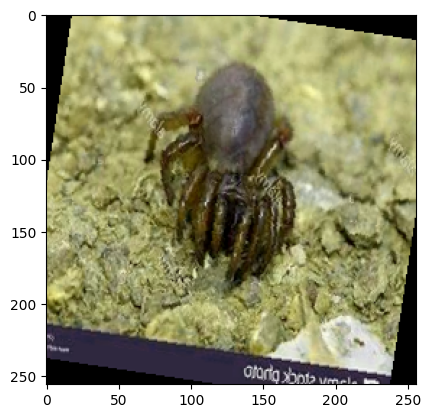

In [6]:
from matplotlib import pyplot as plt
to_pil = T.ToPILImage()
tensor, label = train_dataset[0]
plt.imshow(to_pil(tensor))
full_train_dataset.classes[label]

In [7]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE)

In [8]:
from dataclasses import dataclass, field
from matplotlib import pyplot as plt

@dataclass
class AccLossLog:
    acc: float
    loss: float

@dataclass
class History:
    train: list[AccLossLog] = field(default_factory=list)
    test: list[AccLossLog] = field(default_factory=list)

    def append(self, train_log: AccLossLog, test_log: AccLossLog):
        self.train.append(train_log)
        self.test.append(test_log)
        assert len(self.train) == len(self.test)

    def __len__(self):
        return len(self.train)

    def get_train_accs(self):
        return [log.acc for log in self.train]

    def get_test_accs(self):
        return [log.acc for log in self.test]

    def get_train_losses(self):
        return [log.loss for log in self.train]

    def get_test_losses(self):
        return [log.loss for log in self.test]

    def plot(self):
        """Строит графики точности и loss для train и test"""
        epochs = range(1, len(self) + 1)
        plt.figure(figsize=(12,5))

        # Accuracy
        plt.subplot(1,2,1)
        plt.plot(epochs, self.get_train_accs(), 'b-', label='Train Acc')
        plt.plot(epochs, self.get_test_accs(), 'r-', label='Test Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy per Epoch')
        plt.legend()

        # Loss
        plt.subplot(1,2,2)
        plt.plot(epochs, self.get_train_losses(), 'b-', label='Train Loss')
        plt.plot(epochs, self.get_test_losses(), 'r-', label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()

In [9]:
from tqdm.auto import tqdm

def accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    correct = (y_pred == y_true).float()
    return (correct.sum() / len(correct)).item()

def do_train_step(
    model: nn.Module,
    train_loader: DataLoader[torch.Tensor],
    loss_fn: nn.Module,
    optim: torch.optim.Optimizer,
    device: str
) -> tuple[float, float]:
    model = model.to(device)
    model.train()
    
    train_loss = train_acc = 0
    with tqdm(train_loader, desc="Train", leave=False) as train_bar:
        for X, y in train_bar:
            X, y = X.to(device), y.to(device)

            optim.zero_grad()
    
            out = model(X)
            pred = out.argmax(dim=1)
        
            loss = loss_fn(out, y)
        
            loss.backward()
            optim.step()
        
            train_loss += loss.item()
            train_acc += accuracy(pred, y)
    
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    return train_acc, train_loss

@torch.inference_mode()
def do_test_step(
    model: nn.Module,  
    test_loader: DataLoader[torch.Tensor],
    loss_fn: nn.Module,
    device: str
) -> tuple[float, float]:
    model = model.to(device)
    model.eval()

    test_loss = test_acc = 0
    with tqdm(test_loader, desc="Test", leave=False) as test_bar:
        for X, y in test_bar:
            X, y = X.to(device), y.to(device)
    
            out = model(X)
            pred = out.argmax(dim=1)
            
            loss = loss_fn(out, y)
    
            test_loss += loss.item()
            test_acc += accuracy(pred, y)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    return test_acc, test_loss

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    optim: torch.optim.Optimizer,
    loss_fn: nn.Module,
    epochs: int,
    device: str,
    history: History | None = None
) -> History:
    if not history:
        history = History()

    for epoch in tqdm(range(epochs), desc="Epochs"):
        train = AccLossLog(*do_train_step(model, train_loader, loss_fn, optim, device))
        test = AccLossLog(*do_test_step(model, test_loader, loss_fn, device))
        history.append(train, test)
        
        clear_output(wait=True)

        history.plot()

    return history

In [19]:
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        return F.leaky_relu(self.nn(x) + self.shortcut(x), 0.1)


class BottleneckBlock(nn.Module):
    def __init__(self, in_channels: int, middle_channels: int, out_channels: int):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(middle_channels),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(middle_channels),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(middle_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        return F.leaky_relu(self.nn(x) + self.shortcut(x), 0.1, inplace=True)


class ResModel(nn.Module):
    def __init__(self, in_channels: int, num_classes: int):
        super().__init__()

        bc = 64

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, bc, kernel_size=3, stride=2, padding=1, bias=False), # 256 -> 128
            nn.BatchNorm2d(bc),
            nn.LeakyReLU(0.1, inplace=True),
            
            BottleneckBlock(bc, bc // 4, bc),
            BottleneckBlock(bc, bc // 4, bc * 2), 
            nn.MaxPool2d(3, stride=2, padding=1), # 128 -> 64

            BottleneckBlock(bc * 2, bc // 2, bc * 2),
            BottleneckBlock(bc * 2, bc // 2, bc * 4), 
            nn.MaxPool2d(2), # 64 -> 32

            BottleneckBlock(bc * 4, bc, bc * 4),
            BottleneckBlock(bc * 4, bc, bc * 8),
            nn.MaxPool2d(2), # 32 -> 16
            
            BottleneckBlock(bc * 8, bc * 2, bc * 8),
            BottleneckBlock(bc * 8, bc * 2, bc * 16),
            nn.MaxPool2d(2), # 32 -> 16
            
            BottleneckBlock(bc * 16, bc * 4, bc * 16),
            BottleneckBlock(bc * 16, bc * 4, bc * 16),
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(bc * 16, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [20]:
model = ResModel(3, len(full_train_dataset.classes))

loss_fn = nn.CrossEntropyLoss()

optim = torch.optim.AdamW(params=model.parameters(), lr=1e-3)

history = History()

epochs = 10

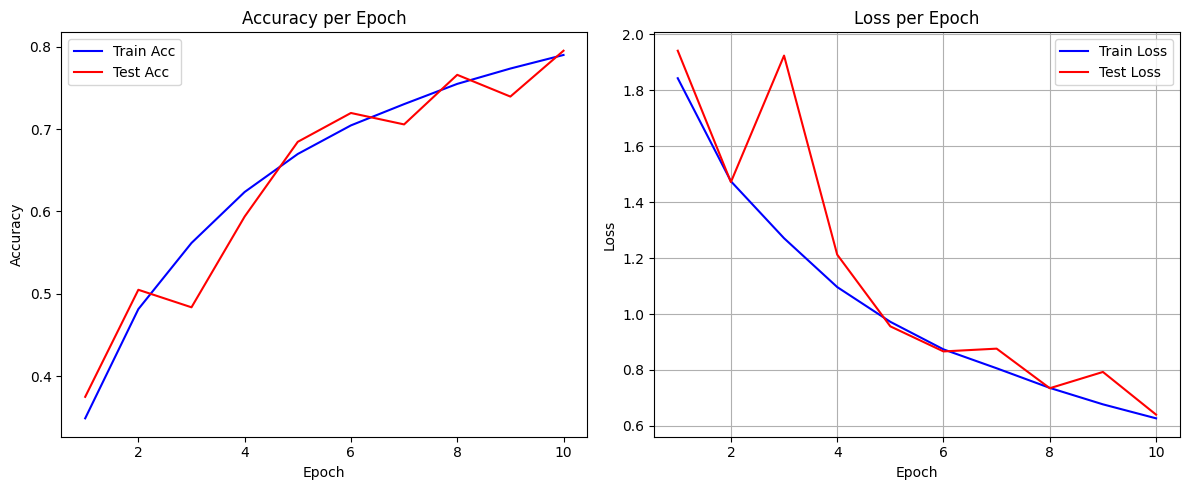

In [21]:
history = train_model(model, train_loader, val_loader, optim, loss_fn, epochs, device, history)

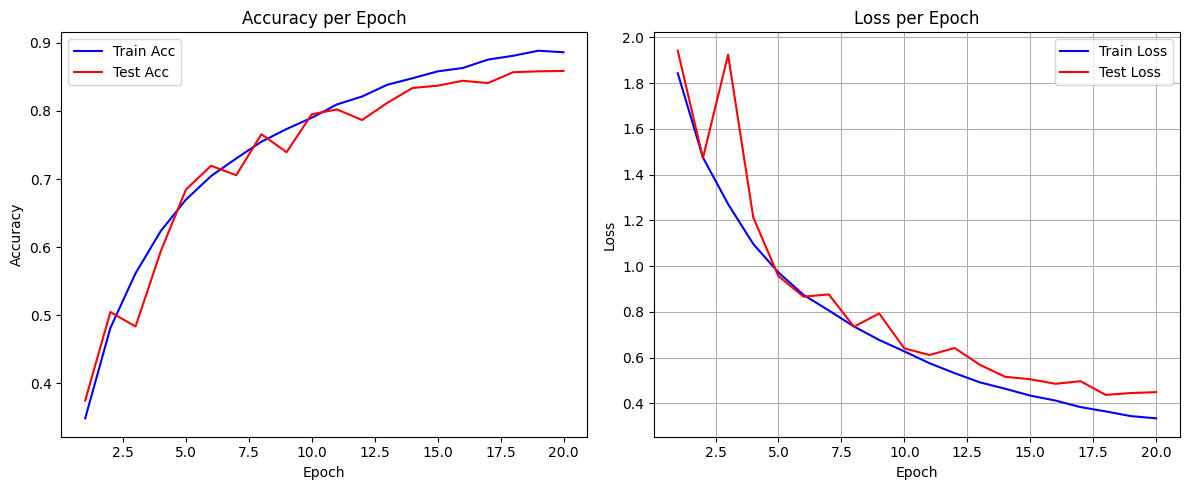

In [22]:
optim.lr = 1e-4
epochs = 10
history = train_model(model, train_loader, val_loader, optim, loss_fn, epochs, device, history)

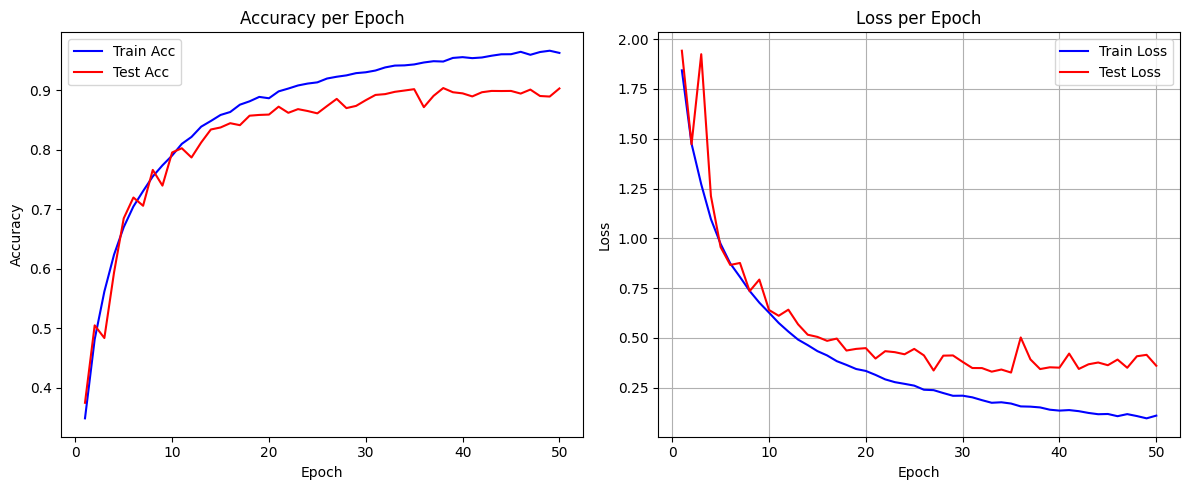

In [23]:
optim.lr = 1e-5
epochs = 30
history = train_model(model, train_loader, val_loader, optim, loss_fn, epochs, device, history)

In [42]:
num = 10
print(sum(x.acc for x in history.test[-num:]) / num)

0.8957201087820357


In [43]:
import torchinfo
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
ResModel                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,728
│    └─BatchNorm2d: 2-2                  128
│    └─LeakyReLU: 2-3                    --
│    └─BottleneckBlock: 2-4              --
│    │    └─Sequential: 3-1              4,544
│    │    └─Identity: 3-2                --
│    └─BottleneckBlock: 2-5              --
│    │    └─Sequential: 3-3              5,696
│    │    └─Sequential: 3-4              8,448
│    └─MaxPool2d: 2-6                    --
│    └─BottleneckBlock: 2-7              --
│    │    └─Sequential: 3-5              17,792
│    │    └─Identity: 3-6                --
│    └─BottleneckBlock: 2-8              --
│    │    └─Sequential: 3-7              22,144
│    │    └─Sequential: 3-8              33,280
│    └─MaxPool2d: 2-9                    --
│    └─BottleneckBlock: 2-10             --
│    │    └─Sequential: 3-9              70,40